In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from pathlib import Path
import numpy as np
base_folder, thresholds_file = 'results/schaefer400', 'global_metrics.csv'
output = Path('results')
atlas_basename = 'schaefer400'
atlas_networks = [dir_.name for dir_ in output.iterdir() if
                              dir_.is_dir() and atlas_basename in dir_.name]
networks_names = {'': 'General', 'Cont': 'Frontoparietal', 'Default': 'Default', 'DorsAttn': 'Atencional dorsal', 'SalVentAttn': 'Atencional ventral/Saliencia'}

In [128]:
def add_curve(thresholds, avg_clustering, lower_error, upper_error, group, ax):
    ax.plot(thresholds, avg_clustering, label=group)
    ax.plot(thresholds, lower_error, alpha=0.1)
    ax.plot(thresholds, upper_error, alpha=0.1)
    ax.legend()
    ax.fill_between(thresholds, lower_error, upper_error, alpha=0.2)
    
def add_statistical_significance(p_at_thresholds, ax, significance_levels, eps=1e-4):
    pvalues = p_at_thresholds[p_at_thresholds.columns[0]]
    labels = ['*' * i for i in range(len(significance_levels), 0, -1)]
    significance_levels.insert(0, 0.0)
    significance_levels.append(1.)
    labels.append('ns')
    categorized_pvalues = pd.cut(pvalues, significance_levels, right=False, labels=labels)
    spacing = pvalues.index[1] - pvalues.index[0] + eps
    
    for label in labels:
        significant_values = categorized_pvalues[categorized_pvalues == label]
        # Build a list of tuples with the start and end of each significant region
        if len(significant_values) > 0 and label not in 'ns':
            significant_regions = [(significant_values.index[0], significant_values.index[0])]
            for i, threshold in enumerate(significant_values.index):
                if i > 0:
                    if threshold - significant_values.index[i - 1] > spacing:
                        significant_regions.append((threshold, threshold))
                    else:
                        significant_regions[-1] = (significant_regions[-1][0], threshold)
            for region in significant_regions:
                ax.plot(region, [ax.get_ylim()[1] * 0.98, ax.get_ylim()[1] * 0.98], marker=f'{label}', linewidth=1, color='k', alpha=0.8)
                
                

In [129]:
def plot_measure(atlas_basename, networks, measure_label, measure_desc, output, filename):
    fig, axes = plt.subplots(figsize=(20, 20), nrows=len(networks) // 2 + 1, ncols=2)
    aucs = {network: {} for network in networks}
    for i, network in enumerate(networks):
        metrics_values = pd.read_csv(output / network / filename, index_col=0)
        ax = axes[i // 2, i % 2]
        groups = sorted(metrics_values['group'].unique())
        for group in groups:
            group_values = metrics_values[metrics_values['group'] == group]
            densities = group_values['threshold'].values
            if measure_label not in group_values.columns:
                continue
            measure_values = group_values[measure_label].values
            lower_error, upper_error = group_values[measure_label] - group_values[f'{measure_label}_ste'], \
                                       group_values[measure_label] + group_values[f'{measure_label}_ste']
            sorted_densities = np.argsort(densities)
            aucs[network][group] = auc(densities[sorted_densities], measure_values[sorted_densities])
            add_curve(densities, measure_values, lower_error, upper_error, group, ax)
        if f'{measure_label}_p' in metrics_values.columns:
            p_at_thresholds = metrics_values[['threshold', f'{measure_label}_p']].drop_duplicates().set_index('threshold')
            add_statistical_significance(p_at_thresholds, ax, significance_levels=[0.01])
        network_name = network.strip(f'{atlas_basename}_') if len(network.split('_')) > 1 else 'Global'
        ax.set_title(f'{network_name}')
        ax.set_xlabel('Connection density')
        ax.set_ylabel(measure_desc)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    fig.suptitle(measure_desc)
    fig.savefig(output / f'{measure_label}.png')
    plt.show()

    return aucs

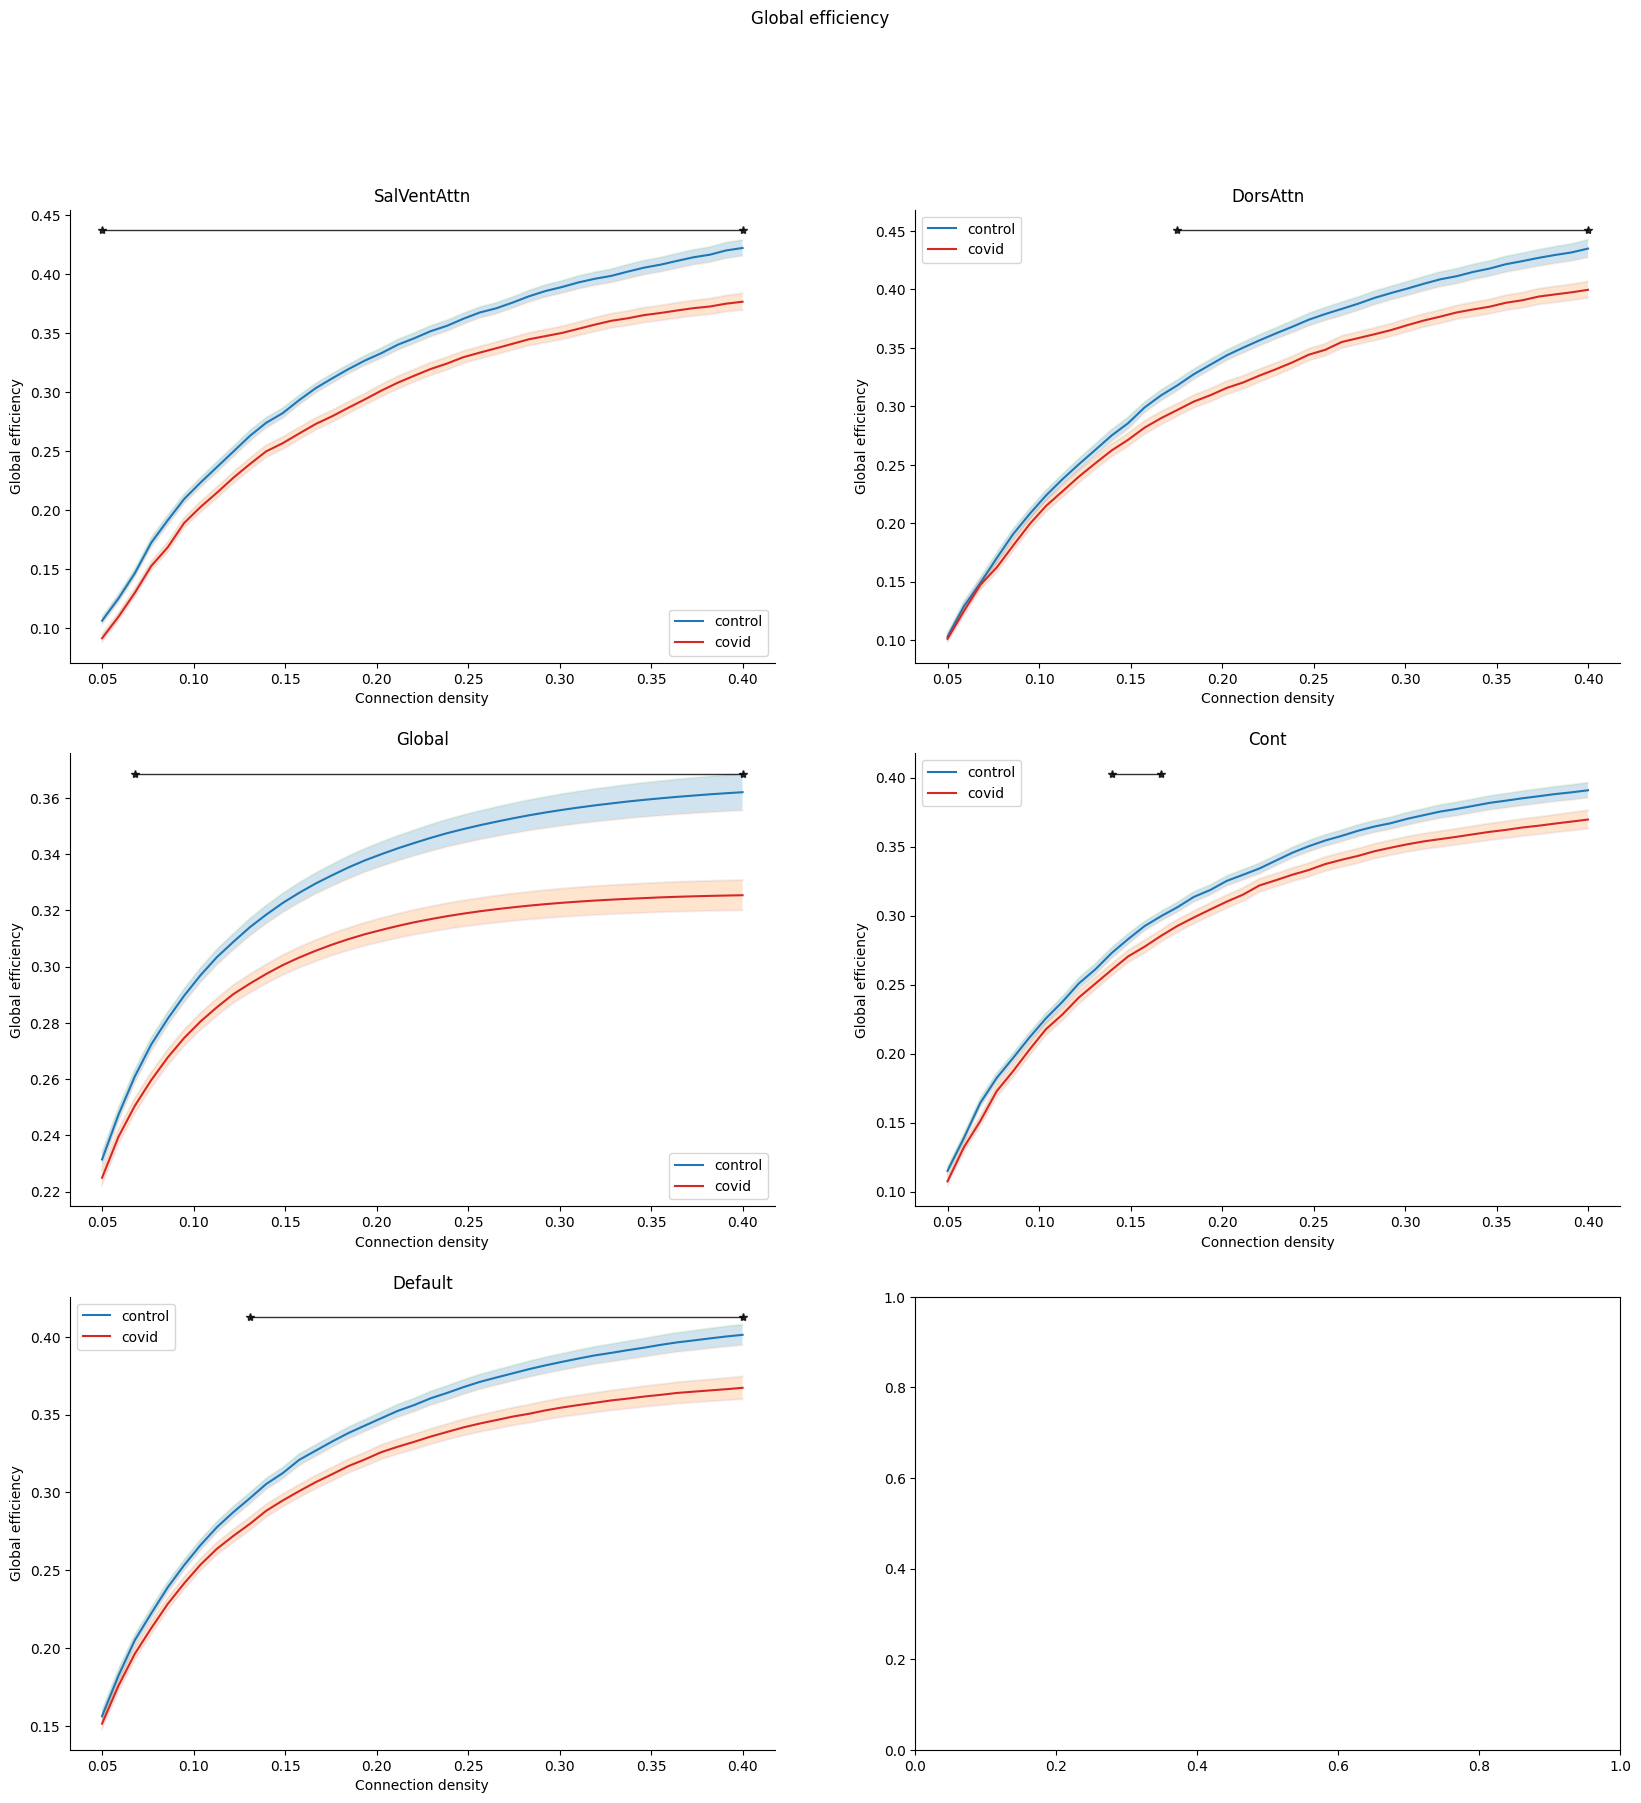

{'schaefer400_SalVentAttn': {'control': 0.11318351790210993,
  'covid': 0.10206714943102595},
 'schaefer400_DorsAttn': {'control': 0.11597727891216181,
  'covid': 0.10777916625214619},
 'schaefer400': {'control': 0.11627490014192798, 'covid': 0.10700105681422553},
 'schaefer400_Cont': {'control': 0.10973684106867873,
  'covid': 0.10435842568252099},
 'schaefer400_Default': {'control': 0.11791852698001602,
  'covid': 0.10988556721842035}}

In [130]:
plot_measure(atlas_basename, atlas_networks, 'global_efficiency', 'Global efficiency', output, 'global_metrics.csv')